# **Download and Imports**

In [27]:
# Fundamental classes
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# Image related
import cv2
from PIL import Image

#Performance Plot
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input

# Time
import time
import datetime

# Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Function**

In [28]:
# date_time function
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:
        return 'Date today: %s' % datetime.date.today()

In [29]:
# Biểu đồ hiệu suất
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

# **Loading Dataset**

In [ ]:
# Đường dẫn thư mục chứa ảnh
train_dir = '/content/drive/MyDrive/Chuyen_de_2/Train'

# Đọc dữ liệu ảnh và nhãn từ thư mục Train
data = []
labels = []
classes = sorted(os.listdir(train_dir))  # Lấy danh sách các thư mục con (0, 1)

for label in classes:
    path = os.path.join(train_dir, label)
    if os.path.isdir(path):  # Chỉ xử lý thư mục, bỏ qua file khác
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                image = Image.open(img_path).resize((128, 128))  # Resize ảnh về 128x128
                data.append(np.array(image))
                labels.append(int(label))  # Nhãn chính là tên thư mục (0, 1)
            except Exception as e:
                print(f"Lỗi khi xử lý {img_name}: {e}")

# Chuyển danh sách thành mảng NumPy
data = np.array(data)
labels = np.array(labels)

# **Data Splitting and conversion**

In [31]:
# Kiểm tra kích thước dữ liệu
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Chuyển nhãn thành dạng one-hot encoding
num_classes = len(classes)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Data shape: (1109, 128, 128, 3)
Labels shape: (1109,)


# **Creating and Compiling the Model**

In [32]:
# Xây dựng mô hình CNN
model = Sequential([
    # Input layer
    Input(shape=X_train.shape[1:]),  # Sử dụng Input() để tránh cảnh báo
    # Convolutional layers
    Conv2D(32, kernel_size=(5, 5), activation='relu'),
    Conv2D(32, kernel_size=(5, 5), activation='relu'),
    # Pooling layer
    MaxPool2D(pool_size=(2, 2)),
    # Dropout layer
    Dropout(0.25),
    # Convolutional layers
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    # Pooling layer
    MaxPool2D(pool_size=(2, 2)),
    # Dropout layer
    Dropout(0.25),
    # Flatten layer
    Flatten(),
    # Dense layers (fully connected)
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Điều chỉnh theo số lượng nhãn
])

# Biên dịch mô hình
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Hiển thị kiến trúc mô hình
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 58, 58, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929,314 (49.32 MB)

 Trainable params: 12,929,314 (49.32 MB)

 Non-trainable params: 0 (0.00 B)

# **Training the Model**

In [33]:
# Huấn luyện mô hình trên GPU (nếu có)
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train, batch_size=16, epochs=35, validation_data=(X_test, y_test))

Epoch 1/35
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.5746 - loss: 60.9251 - val_accuracy: 0.6396 - val_loss: 0.6720
Epoch 2/35
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6371 - loss: 0.6652 - val_accuracy: 0.6667 - val_loss: 0.6100
Epoch 3/35
56/56 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6983 - loss: 0.5825 - val_accuracy: 0.8108 - val_loss: 0.4631
Epoch 4/35
56/56 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9059 - loss: 0.2483 - val_accuracy: 0.9685 - val_loss: 0.1748
Epoch 5/35
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9781 - loss: 0.0938 - val_accuracy: 0.9820 - val_loss: 0.0717
Epoch 6/35
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9869 - loss: 0.0458 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 7/35
56/56 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9969 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 8/35
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9965 - loss: 0.0088 - val_accuracy: 1.0000 - 

# **Visualizing the performance of the Model during Training Phase**

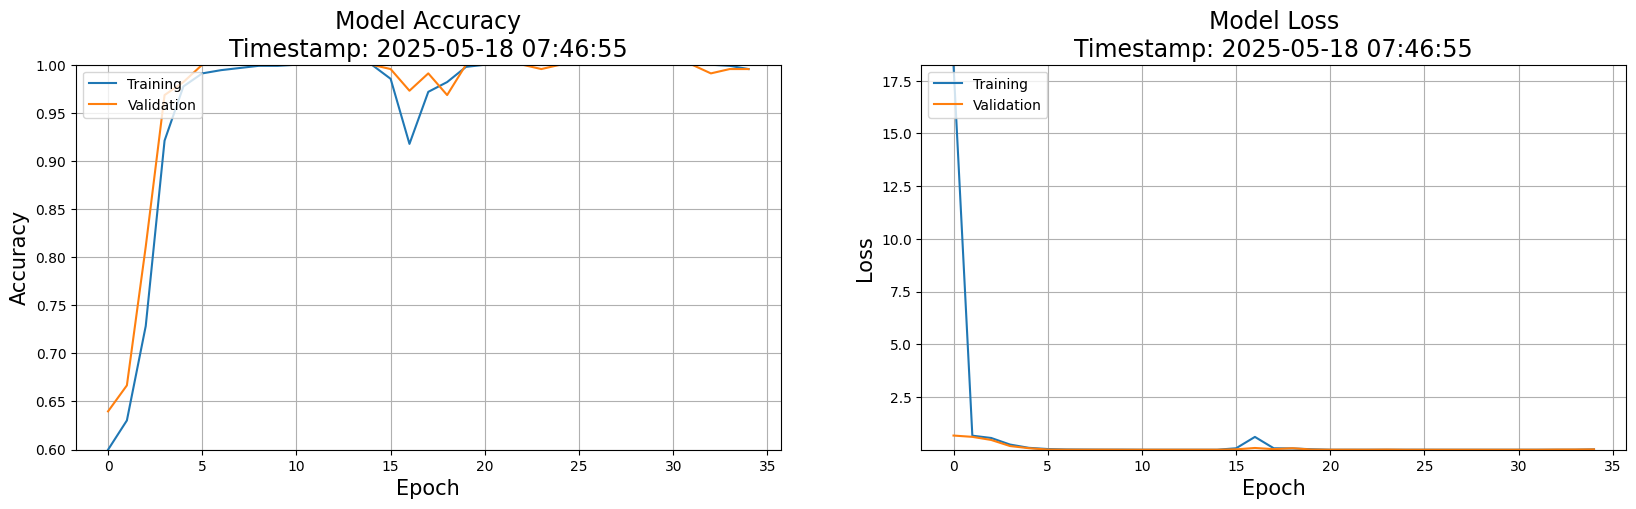

In [34]:
plot_performance(history=history1)

# **Loading Test Dataset and Evaluating the Model**

In [40]:
# testing accuracy on test dataset
from sklearn.metrics import accuracy_score

# Kiểm tra trên tập test
y_test_df = pd.read_csv('/content/drive/MyDrive/Chuyen_de_2/Test.csv')
labels_test = y_test_df["ClassId"].values
imgs_test = y_test_df["Path"].values

# Tiền xử lý ảnh từ Test.csv
test_data = []
for img in imgs_test:
    img_path = os.path.join('/content/drive/MyDrive/Chuyen_de_2/', img)
    try:
        image = Image.open(img_path).resize((128, 128))
        image = np.array(image) / 255.0  # Chuẩn hóa ảnh
        test_data.append(image)
    except Exception as e:
        print(f"Lỗi đọc {img}: {e}")

X_test = np.array(test_data)

# Dự đoán
with tf.device('/GPU:0'):
    predictions = np.argmax(model.predict(X_test), axis=-1)

# Đánh giá độ chính xác
from sklearn.metrics import accuracy_score
# print("Test Accuracy:", accuracy_score(labels_test, predictions))
print(f"Test Accuracy: {accuracy_score(labels_test, predictions):.16f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 931ms/step
Test Accuracy: 0.9939393939393939


# **Savinng the Model**

In [41]:
# Saving the Model
model.save('/content/drive/MyDrive/Chuyen_de_2/complete_training/traffic_classifier.h5')

In [42]:
# Saving the Model
model.save('/content/drive/MyDrive/Chuyen_de_2/complete_training/traffic_classifier.keras')